In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')

Using TensorFlow backend.


!ls
・!でコマンド確認可能

In [3]:
# Load the data
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")

In [4]:
test

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


・画像はグレースケール
・trainには学習用の答えlabel
・testにはlabelなし？

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

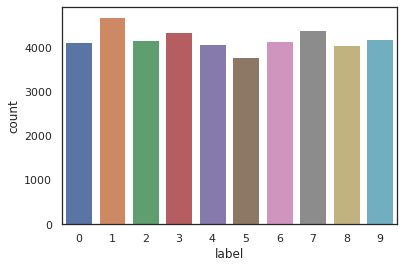

In [5]:
Y_train = train["label"]

# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1) 

# free some space
del train 

g = sns.countplot(Y_train)

Y_train.value_counts()

In [6]:
# Check the data
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [7]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

ノーマライゼーション：画素値を0-1に
pythonのreshape(-1は？)

In [8]:
# Normalize the data
X_train = X_train / 255.0
test = test / 255.0

reshapeで
[データ数, height, width, color_channels]

In [9]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [10]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 10)

2.6 Split training and valdiation set

In [11]:
# Set the random seed
random_seed = 2

In [12]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

trainデータ：37800

In [13]:
X_train.shape

(37800, 28, 28, 1)

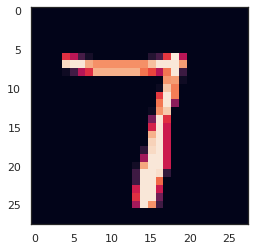

In [14]:
# Some examples
g = plt.imshow(X_train[1][:,:,0])

In [14]:
7 * 7* 64

3136

In [15]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

model = Sequential()

#計算①
# 28 * 28
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))

# 28 * 28* 32
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
# 28 * 28* 32
model.add(MaxPool2D(pool_size=(2,2)))
# MaxPool2DのストライドデフォルトはNoneで，pool_sizeと等しくなる．

# 14 * 14 * 32
model.add(Dropout(0.25))
# Dropout (重みを指定した割合だけ0にして無効にする．)
#この場合，1/4をランダムに無効にする．アンサンブルして結果を良くする．

#計算②
# 14 * 14 * 32
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))

# 14 * 14 * 64
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))

# 14 * 14 * 64
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

# 7 * 7 * 64
model.add(Dropout(0.25))

# 7 * 7 * 64
model.add(Flatten())

# 3136
# Denseはaffineと同じように，ノードを結ぶ働きをする．
model.add(Dense(256, activation = "relu")) # 出力は256個のノード

# 256
model.add(Dropout(0.5))

# 256
model.add(Dense(10, activation = "softmax"))# 出力は10個のノード

# 10
# Denseは最後の層だけ使うのが普通．

In [16]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
#lr : 学習率
# rho, epsilon : rmsiのパラメータ

In [17]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
#softmaxは出力が10クラスの確率[0,0,0.8,0,0,0,0,0,0.2,0] = 足したら1
# カテゴリカルクロスエントリピー ：ラベル[0,0,1,0,0,0,0,0,0,0] とエントロピー計算

In [18]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [19]:
epochs = 1 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 86

In [20]:
# Without data augmentation i obtained an accuracy of 0.98114
#history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
#          validation_data = (X_val, Y_val), verbose = 2)

In [21]:
# With data augmentation to prevent overfitting (accuracy 0.99286)
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

ここで計算

In [22]:
# Fit the model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/1


KeyboardInterrupt: 

In [ ]:
#modelの構造保存
json_string = model.to_json()
open('digit_recognizer_model.json', 'w').write(json_string)

In [ ]:
#重みの保存
model.save_weights('digit_recognizer_weights.h5')

# 訓練結果

In [ ]:
history.history

In [ ]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [ ]:
# Look at confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes "FROM" one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations "FROM" one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 

#あるカラムだけ1で他のカラムは0な行列の表現。カテゴリー変数でよく使います。
#古典的な統計の教科書では「ダミー変数」という言い方もします。
#PandasのOneHotベクトルを作る関数get_dummiesはこれが由来です。

# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

error見る．

In [ ]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

# Predict Test_data

## modelから行う方法

In [50]:
test.shape

(28000, 28, 28, 1)

In [ ]:
# predict results
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

In [ ]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("cnn_mnist_datagen.csv",index=False)

## モデル構造ファイルと重みから予測する方法
モデル構造：digit_recognizer_model.json <br>
重みファイル：digit_recognizer_weights.h5 <br>

In [17]:
from keras.models import model_from_json

In [18]:
# モデルの読み込み
model = model_from_json(open('digit_recognizer_model.json', 'r').read())

#重みの読み込み
model.load_weights('mnist_mlp_weights.h5')

In [19]:
print(test[0:100].shape)
results = model.predict(test[0:100])

(100, 28, 28, 1)


In [20]:
# data_num * class_num
print(results.shape)

predicted = np.argmax(results, axis = 1)
print(predicted)

(100, 10)
[2 0 9 0 3 7 0 3 0 3 5 7 4 0 4 3 3 1 9 0 9 1 1 5 7 4 2 7 4 7 7 5 4 2 6 2 5
 5 1 6 7 7 4 9 8 7 8 2 6 7 6 8 8 3 8 2 1 2 2 0 4 1 7 0 0 0 1 9 0 1 6 5 8 8
 2 8 9 9 2 3 5 4 1 0 9 2 4 3 6 7 2 0 6 6 1 4 3 9 7 4]


## Grad-Cam ++

In [21]:
import PIL

In [22]:
import numpy as np
import argparse
import keras
import sys
from keras import backend as K
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.applications.resnet50 import ResNet50
from keras.models import Sequential

In [ ]:
import cv2

In [29]:
def Grad_Cam_plus_plus(input_model, layer_name, x, row, col):

    model = input_model

    # 前処理
    #X = np.expand_dims(x, axis=0)
    #X = X.astype('float32')
    #preprocessed_input = X / 255.0

    # 予測クラスの算出
    #predictions = model.predict(preprocessed_input)
    print("入力：" + str(x.shape))
    predictions = model.predict(x)
    class_idx = np.argmax(predictions[0])

    #  使用する重みの抽出、高階微分の計算
    class_output = model.layers[-1].output
    conv_output = model.get_layer(layer_name).output
    grads = K.gradients(class_output, conv_output)[0]
    #first_derivative：１階微分
    first_derivative = K.exp(class_output)[0][class_idx] * grads
    #second_derivative：２階微分
    second_derivative = K.exp(class_output)[0][class_idx] * grads * grads
    #third_derivative：３階微分
    third_derivative = K.exp(class_output)[0][class_idx] * grads * grads * grads

    #関数の定義
    gradient_function = K.function([model.input], [conv_output, first_derivative, second_derivative, third_derivative])  # model.inputを入力すると、conv_outputとgradsを出力する関数


    conv_output, conv_first_grad, conv_second_grad, conv_third_grad = gradient_function([x])
    conv_output, conv_first_grad, conv_second_grad, conv_third_grad = conv_output[0], conv_first_grad[0], conv_second_grad[0], conv_third_grad[0]

    #alphaを求める
    global_sum = np.sum(conv_output.reshape((-1, conv_first_grad.shape[2])), axis=0)
    alpha_num = conv_second_grad
    alpha_denom = conv_second_grad*2.0 + conv_third_grad*global_sum.reshape((1,1,conv_first_grad.shape[2]))
    alpha_denom = np.where(alpha_denom!=0.0, alpha_denom, np.ones(alpha_denom.shape))
    alphas = alpha_num / alpha_denom

    #alphaの正規化
    alpha_normalization_constant = np.sum(np.sum(alphas, axis = 0), axis = 0)
    alpha_normalization_constant_processed = np.where(alpha_normalization_constant != 0.0, alpha_normalization_constant, np.ones(alpha_normalization_constant.shape))
    alphas /= alpha_normalization_constant_processed.reshape((1,1,conv_first_grad.shape[2]))

    #wの計算
    weights = np.maximum(conv_first_grad, 0.0)
    deep_linearization_weights = np.sum((weights * alphas).reshape((-1, conv_first_grad.shape[2])))

    #Lの計算
    grad_CAM_map = np.sum(deep_linearization_weights * conv_output, axis=2)
    grad_CAM_map = np.maximum(grad_CAM_map, 0)
    grad_CAM_map = grad_CAM_map / np.max(grad_CAM_map)
    
    #ヒートマップを描く
    print("出力：" + str(np.shape(grad_CAM_map)))
    #grad_CAM_map = cv2.resize(grad_CAM_map, (row, col), cv2.INTER_LINEAR)
    #jetcam = cv2.applyColorMap(np.uint8(255 * grad_CAM_map), cv2.COLORMAP_JET)  # モノクロ画像に疑似的に色をつける
    #jetcam = (np.float32(jetcam) + x / 2)   # もとの画像に合成

    return grad_CAM_map

In [26]:
# layer_name : 最後のconvolution層直後のactivation層の名前を確認したい．
# activation層（活性化関数を使っている層）がconvolution層に含まれている場合
# ⇒ convolution層の名前でよい．
# 層の名前はmodel.summary()で確認できる．
model.summary()
# これよりconv2d_4が対象のactivation層になる

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)         

In [30]:
#次のTodo★
#以下の関数を通るようにする．（上で実装したpredictionを通るようにする．）
 
#from keras.applications.vgg16 import VGG16
from keras import backend as K

# Model : 上で定義したmodel
model = model

#Model : VGG16 (.h5のダウンロードに10分かかる)
#model = VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None)

#Model : Resvet(.h5のダウンロードに10分かかる)
#model = ResNet50(weights = 'imagenet')

img = test[0:5] #shapeは datanum(5) * 28pix * 28pix * 1の形に

target_layer = 'conv2d_4'
row = 28
col = 28

img_GCAMplusplus = Grad_Cam_plus_plus(model, target_layer, img, row, col)
#img_Gplusplusname = args.image_path+"_GCAM++_%s.jpg"%args.model
#cv2.imwrite(img_Gplusplusname, img_GCAMplusplus)

入力：(5, 28, 28, 1)
出力：(14, 14)


In [34]:
# 次回Todo
# cv2をimportして以下の計算を回す．

In [33]:
img_GCAMplusplus_resized = img_GCAMplusplus.resize((28,28))

ValueError: cannot resize an array that references or is referenced
by another array in this way.
Use the np.resize function or refcheck=False

In [ ]:
#grad_CAM_map = cv2.resize(grad_CAM_map, (row, col), cv2.INTER_LINEAR)
#jetcam = cv2.applyColorMap(np.uint8(255 * grad_CAM_map), cv2.COLORMAP_JET)  # モノクロ画像に疑似的に色をつける
#jetcam = (np.float32(jetcam) + x / 2)   # もとの画像に合成

In [56]:
img_GCAMplusplus.shape

(14, 14)

# TIPS

1 : 線形補間<br>
- https://qiita.com/ground0state/items/5fa0743837f1bcb374ca

2 : テストデータとバリデーションデータの分割
- from sklearn.model_selection import train_test_split

3 : 混合行列の描写
 - 混同行列（confusion matrix）はクラス分類問題の結果を「実際のクラス」と「予測したクラス」を軸にしてまとめたもの。
 - from sklearn.metrics import confusion_matrix 
 
4 : ループ処理を楽にするitertools 
 - https://qiita.com/__cooper/items/ff1d3d71088abb5d0849
```
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
```

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

X_train = train.drop(labels = ["label"],axis = 1) 

5 : pandasのデータの抜き取り
- X_train = train.drop(labels = ["label"],axis = 1) 

6 : ヒストグラム等，numpyが使いづらい時はseabornを使うと良い．
- g = sns.countplot(Y_train)

7 : isnull(), any(), describe()の併せ技（dataのチェックが出来る．）
X_train.isnull().any().describe()

8 : "to_categorical" (from keras.utils.np_utils import to_categorical)
- Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
- e.g. Y_train = to_categorical(Y_train, num_classes = 10)

9 : 訓練データとバリデーションデータへの分割
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

10 : kerasの使い方．
- model = Sequential() : 
- model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1))) : 
- model.add(MaxPool2D(pool_size=(2,2)))
- model.add(Dropout(0.25))
- model.add(Flatten())
- model.add(Dense(256, activation = "relu")) # 出力は256個のノード

11 : Optimizerの使い方
 - optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
 
12 : Compile model 
- model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

13 : set learning rate
- learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

14 :sa


* 次回Todo
 - セル19から作る．
 - 上の関数からまとめノート作っておく．